# Monografía Final
## Redes Neuronales - FIUBA
### Alumno: Julián Stejman

En este documento se utilizará una red neuronal entrenada con un algoritmo de aprendizaje por refuerzo PPO (Proximal Policy Optimization) que aprendiese a jugar niveles de Super Mario Bros para la NES. Para ello, se utilizará el entorno de OpenAI Gym, que simula el juego de Super Mario Bros, junto con una arquitectura Actor-Critic basada en capas convolucionales y frame stacking para capturar información temporal.

In [1]:
%pip install gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import RIGHT_ONLY
import torch
import torch.nn as nn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.4 MB/s eta 0:00:00
  Created wheel for nes-py: filename=nes_py-8.2.1-cp310-cp310-linux_x86_64.whl size=535720 sha256=264a9d37ba1bde4a0a6b7e91bfc81e50d2388b942420e83ea487a419820858af
  Stored in directory: /root/.cache/pip/wheels/34/a7/d5/9aa14b15df740a53d41f702e4c795731b6c4da7925deb8476c
Successfully built nes-py
Note: you may need to restart the kernel to use updated packages.


In [2]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Si se eliminara en la siguiente celda la línea que dice %%skip, se podría ver una simulación simple de como funciona el emulador del juego con el entorno. 

In [3]:

%%skip
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

done = True
for step in range(5000):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()

env.close()

La idea sería armar una red neuronal convolucional para poder interpretar de las imágenes recibidas una posible acción para que tomara el personaje del juego. Esta red luego utilizará un algoritmo de aprendizaje por refuerzo para poder mejorar su desempeño.

La arquitectura utiliza una red Actor-Critic con capas convolucionales que procesan 4 frames apilados del juego. Al recibir múltiples frames consecutivos, la CNN puede inferir velocidad y dirección del movimiento sin necesidad de una capa recurrente. El Actor predice la distribución de probabilidades sobre acciones (policy), mientras que el Critic estima el valor esperado del estado para el cálculo del advantage. Esta es la misma arquitectura que utiliza internamente Stable Baselines3 con `CnnPolicy`, y la que DeepMind usó originalmente para Atari.

In [4]:
class PPOActorCritic(nn.Module):
    def __init__(self, input_shape, num_actions, hidden_size=512):
        super().__init__()
        
        # Capas convolucionales para procesamiento de imágenes
        # Arquitectura estándar Nature DQN (Mnih et al., 2015)
        self.image_processing = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Calcular tamaño de salida de las conv
        flatten_size = self._get_flatten_size(input_shape)
        
        # Feature extractor compartido
        self.shared_fc = nn.Sequential(
            nn.Linear(flatten_size, hidden_size),
            nn.ReLU()
        )
        
        # Actor: predice distribución sobre acciones
        self.actor = nn.Linear(hidden_size, num_actions)
        
        # Critic: estima valor del estado
        self.critic = nn.Linear(hidden_size, 1)
        
        # Inicialización ortogonal (mejora estabilidad del entrenamiento)
        self._init_weights()
        
    def _get_flatten_size(self, input_shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            output = self.image_processing(dummy_input)
            return output.shape[1]
    
    def _init_weights(self):
        """Inicialización ortogonal estándar para PPO"""
        for module in self.image_processing:
            if isinstance(module, nn.Conv2d):
                nn.init.orthogonal_(module.weight, gain=nn.init.calculate_gain('relu'))
                nn.init.zeros_(module.bias)
        nn.init.orthogonal_(self.shared_fc[0].weight, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(self.shared_fc[0].bias)
        nn.init.orthogonal_(self.actor.weight, gain=0.01)  # Pequeño para política inicial uniforme
        nn.init.zeros_(self.actor.bias)
        nn.init.orthogonal_(self.critic.weight, gain=1.0)
        nn.init.zeros_(self.critic.bias)
    
    def forward(self, x):
        """
        x: (batch_size, channels, height, width) — channels = 4 frames apilados
        """
        features = self.image_processing(x)
        features = self.shared_fc(features)
        
        action_logits = self.actor(features)
        value = self.critic(features)
        
        return action_logits, value

In [5]:
frame_stack_count = 4
dimensions = 84
input_shape = (frame_stack_count, dimensions, dimensions)
num_actions = len(RIGHT_ONLY)

test_model = PPOActorCritic(input_shape, num_actions)
dummy_state = torch.zeros(1, *input_shape)  # (batch_size, channels, height, width)
action_logits, value = test_model(dummy_state)
print(f"Action logits shape: {action_logits.shape}")
print(f"Value shape: {value.shape}")
print(f"Number of actions: {num_actions}")
print(f"Total parameters: {sum(p.numel() for p in test_model.parameters()):,}")

Action logits shape: torch.Size([1, 5])
Value shape: torch.Size([1, 1])
Number of actions: 5
Total parameters: 1,687,206


Para enviar a la red, se toman las siguientes decisiones de preprocesamiento estándar en RL:

1. **Frame skip (4)**: Repetir cada acción durante 4 frames consecutivos. Esto reduce la cantidad de decisiones que debe tomar el agente y hace el entrenamiento ~4x más rápido.
2. **Escala de grises**: Convertir de RGB a blanco y negro (reduce de 3 canales a 1).
3. **Resolución 84×84**: Tamaño estándar para RL en juegos, suficiente para capturar la información visual relevante.
4. **Frame stacking (4)**: Apilar los últimos 4 frames como canales, resultando en un tensor `(4, 84, 84)`. Esto permite que la CNN pueda inferir velocidad y dirección del movimiento.

Todo esto se implementa como wrappers del entorno, siguiendo la convención de OpenAI Gym.

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


State shape: (4, 84, 84)  ← debe ser (4, 84, 84)
Action space: 5 acciones: [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B']]


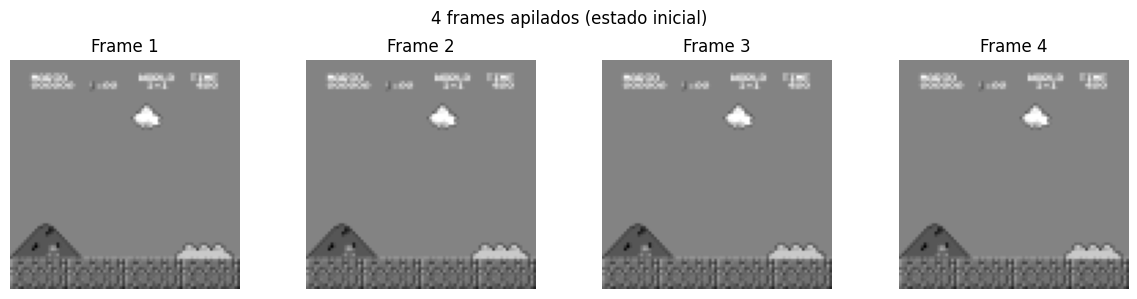

In [6]:
import gym
import numpy as np
from gym import Wrapper, ObservationWrapper
from gym.wrappers import GrayScaleObservation, FrameStack, ResizeObservation
from gym import spaces

class SkipFrame(Wrapper):
    """
    Repite la misma acción durante `skip` frames y acumula la recompensa.
    
    Esto es estándar en RL para Atari/Mario porque:
    - Frames consecutivos son casi idénticos, no tiene sentido decidir cada uno
    - Reduce 4x la cantidad de decisiones → entrenamiento más rápido
    - Reduce ruido en la señal de reward
    """
    def __init__(self, env, skip=4):
        super().__init__(env)
        self._skip = skip
    
    def step(self, action):
        total_reward = 0.0
        for _ in range(self._skip):
            state, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return state, total_reward, done, info

class SqueezeObservation(ObservationWrapper):
    """
    Elimina la dimensión de canal trailing si es 1: (84,84,1) → (84,84).
    
    Necesario porque algunas versiones de gym producen (H,W,1) después de
    GrayScaleObservation + ResizeObservation, y FrameStack lo apilaría como
    (4,84,84,1) en vez de (4,84,84).
    """
    def __init__(self, env):
        super().__init__(env)
        obs = self.observation_space
        if len(obs.shape) == 3 and obs.shape[-1] == 1:
            self.observation_space = spaces.Box(
                low=obs.low.squeeze(-1), high=obs.high.squeeze(-1), dtype=obs.dtype
            )

    def observation(self, obs):
        if obs.ndim == 3 and obs.shape[-1] == 1:
            return obs.squeeze(-1)
        return obs

def make_mario_env(world=1, stage=1):
    """Crea el entorno de Mario con todos los wrappers estándar de RL."""
    env = gym_super_mario_bros.make(f'SuperMarioBros-{world}-{stage}-v0')
    env = JoypadSpace(env, RIGHT_ONLY)
    env = SkipFrame(env, skip=4)
    env = ResizeObservation(env, shape=(dimensions, dimensions))    # (84, 84, 3)
    env = GrayScaleObservation(env, keep_dim=False)                 # (84, 84) idealmente
    env = SqueezeObservation(env)                                   # (84, 84) garantizado
    env = FrameStack(env, num_stack=frame_stack_count)              # (4, 84, 84)
    return env

# Crear entorno y verificar
env = make_mario_env()
reset_result = env.reset()
state = reset_result[0] if isinstance(reset_result, tuple) else reset_result
state_np = np.array(state)
print(f"State shape: {state_np.shape}  ← debe ser (4, 84, 84)")
print(f"Action space: {env.action_space.n} acciones: {RIGHT_ONLY}")
assert state_np.shape == (4, 84, 84), f"Shape incorrecto: {state_np.shape}"

# Visualizar los 4 frames apilados
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axes[i].imshow(state_np[i], cmap='gray')
    axes[i].set_title(f'Frame {i+1}')
    axes[i].axis('off')
plt.suptitle('4 frames apilados (estado inicial)')
plt.tight_layout()
plt.show()

Para el entrenamiento con PPO vectorizado, se utiliza un rollout buffer que acumula `n_steps` pasos de interacción desde `n_envs` entornos en paralelo. En cada paso, los N entornos avanzan simultáneamente, produciendo N transiciones diversas. A diferencia del enfoque con un solo entorno (donde los datos están altamente correlacionados), esto genera batches con trayectorias variadas que estabilizan significativamente los gradientes de PPO.

In [7]:
class VecRolloutBuffer:
    """
    Buffer on-policy para PPO vectorizado: almacena experiencias de N entornos en paralelo.
    
    A diferencia del buffer episódico (1 env), este buffer recolecta n_steps pasos
    de n_envs entornos simultáneamente, produciendo batches de tamaño n_steps * n_envs.
    
    Estructura:
    - Cada array tiene shape (n_steps, n_envs, ...)
    - Al finalizar el rollout, se aplana a (n_steps * n_envs, ...) para el update de PPO
    
    Esto reduce la correlación entre muestras y estabiliza el entrenamiento.
    """
    def __init__(self, n_steps, n_envs, obs_shape):
        self.n_steps = n_steps
        self.n_envs = n_envs
        self.obs_shape = obs_shape
        self.ptr = 0
        self.clear()
    
    def store(self, states, actions, rewards, values, log_probs, dones):
        """Almacena un paso de todos los N entornos simultáneamente."""
        self.states[self.ptr] = states
        self.actions[self.ptr] = actions
        self.rewards[self.ptr] = rewards
        self.values[self.ptr] = values
        self.log_probs[self.ptr] = log_probs
        self.dones[self.ptr] = dones
        self.ptr += 1
    
    def compute_returns_and_advantages(self, last_values, gamma=0.99, gae_lambda=0.95):
        """
        Calcula returns y advantages con GAE para todos los entornos en paralelo.
        
        last_values: array de shape (n_envs,) — V(s_final) de cada entorno.
        
        GAE se computa independientemente por entorno pero en forma vectorizada.
        Cuando un entorno termina (done=True), el advantage se corta (no propaga
        hacia atrás a través del reset).
        """
        advantages = np.zeros((self.n_steps, self.n_envs), dtype=np.float32)
        gae = np.zeros(self.n_envs, dtype=np.float32)
        
        for t in reversed(range(self.n_steps)):
            if t == self.n_steps - 1:
                next_values = last_values
            else:
                next_values = self.values[t + 1]
            
            next_non_terminal = 1.0 - self.dones[t]
            delta = self.rewards[t] + gamma * next_values * next_non_terminal - self.values[t]
            gae = delta + gamma * gae_lambda * next_non_terminal * gae
            advantages[t] = gae
        
        returns = advantages + self.values
        return returns, advantages
    
    def get_flattened(self, returns, advantages):
        """
        Aplana (n_steps, n_envs, ...) → (n_steps * n_envs, ...) para PPO.
        Retorna tensores listos para mini-batch SGD.
        """
        batch_size = self.n_steps * self.n_envs
        return (
            self.states.reshape(batch_size, *self.obs_shape),
            self.actions.reshape(batch_size),
            self.log_probs.reshape(batch_size),
            returns.reshape(batch_size),
            advantages.reshape(batch_size),
        )
    
    def clear(self):
        self.states = np.zeros((self.n_steps, self.n_envs, *self.obs_shape), dtype=np.float32)
        self.actions = np.zeros((self.n_steps, self.n_envs), dtype=np.int64)
        self.rewards = np.zeros((self.n_steps, self.n_envs), dtype=np.float32)
        self.values = np.zeros((self.n_steps, self.n_envs), dtype=np.float32)
        self.log_probs = np.zeros((self.n_steps, self.n_envs), dtype=np.float32)
        self.dones = np.zeros((self.n_steps, self.n_envs), dtype=np.float32)
        self.ptr = 0
    
    def __len__(self):
        return self.n_steps * self.n_envs

print(f"✅ VecRolloutBuffer cargado (buffer vectorizado para N entornos)")


✅ VecRolloutBuffer cargado (buffer vectorizado para N entornos)


## Función de Entrenamiento PPO Vectorizado

### ¿Por qué múltiples entornos?

PPO es un algoritmo on-policy: usa los datos recolectados una sola vez y los descarta. Con **un solo entorno**, cada batch proviene de una única trayectoria larga, lo que produce:
- Datos altamente correlacionados (frames consecutivos son casi iguales)
- Gradientes ruidosos → updates inestables
- Señal de aprendizaje débil (media móvil plana, alta varianza)

Al usar **N entornos en paralelo** (típicamente 8), cada batch contiene N trayectorias independientes. Esto:
- **Reduce correlación**: muestras más diversas por update
- **Estabiliza gradientes**: el promedio sobre N trayectorias reduce el ruido
- **Mejora sample efficiency**: más datos por update → convergencia más rápida

### Flujo del entrenamiento vectorizado:
```
Para cada update (total_timesteps / (n_steps * n_envs)):
  1. Recolectar n_steps pasos de los N entornos simultáneamente
     - Forward pass batch: N observaciones → CNN → N acciones
     - Guardar (states, actions, rewards, log_probs, values, dones) × N
  2. Bootstrap V(s_final) de cada entorno
  3. Calcular GAE vectorizado (independiente por entorno)
  4. Aplanar (n_steps × n_envs) → batch completo
  5. Para cada época (4):
     - Barajar y dividir en mini-batches
     - PPO clipped loss + value loss - entropía
     - Gradient clipping y update
```

### Auto-reset:
Cuando un entorno termina (`done=True`), se resetea automáticamente y continúa. Las estadísticas del episodio terminado se guardan en `info['episode']` para tracking.

## Preprocesamiento con Wrappers de Gym

El pipeline de preprocesamiento se implementa como una cadena de wrappers, donde cada uno transforma la observación del entorno:

```
SuperMarioBros-v0  →  JoypadSpace  →  SkipFrame  →  GrayScale  →  Resize  →  FrameStack
     (240,256,3)      (reduce acciones)  (repite 4)   (H,W,1→H,W)  (84,84)    (4,84,84)
```

### ¿Por qué estos wrappers?

| Wrapper | Qué hace | Por qué |
|---------|----------|---------|
| `JoypadSpace` | Reduce 256 acciones → 5 (RIGHT_ONLY) | Espacio de acciones más pequeño = más fácil de aprender |
| `SkipFrame(4)` | Repite acción 4 frames, acumula reward | 4x más rápido, frames consecutivos son casi iguales |
| `GrayScale` | RGB → escala de grises | 3x menos datos, el color no aporta información útil |
| `Resize(84,84)` | Redimensiona a 84×84 | Tamaño estándar, reduce cómputo en CNN |
| `FrameStack(4)` | Apila últimos 4 frames como canales | Permite inferir velocidad y dirección |

**Nota**: Todo el preprocesamiento ocurre en los wrappers del entorno, no manualmente en el loop de entrenamiento. Esto es más limpio y menos propenso a errores.

In [8]:
def diagnostico_training(rewards, window=10):
    """
    Análisis detallado del entrenamiento para detectar problemas
    """
    print(f"\n{'='*70}")
    print(f"🔍 DIAGNÓSTICO DEL ENTRENAMIENTO")
    print(f"{'='*70}\n")
    
    # 1. Estadísticas básicas
    print(f"📊 Estadísticas Generales:")
    print(f"   Total episodios: {len(rewards)}")
    print(f"   Reward promedio: {np.mean(rewards):.2f}")
    print(f"   Reward std: {np.std(rewards):.2f}")
    print(f"   Reward máximo: {max(rewards):.2f}")
    print(f"   Reward mínimo: {min(rewards):.2f}\n")
    
    # 2. Tendencia
    if len(rewards) >= 20:
        first_half = rewards[:len(rewards)//2]
        second_half = rewards[len(rewards)//2:]
        improvement = np.mean(second_half) - np.mean(first_half)
        
        print(f"📈 Tendencia:")
        print(f"   Primera mitad avg: {np.mean(first_half):.2f}")
        print(f"   Segunda mitad avg: {np.mean(second_half):.2f}")
        print(f"   Mejora: {improvement:+.2f} ", end="")
        
        if improvement > 50:
            print("✅ (Buena progresión)")
        elif improvement > 0:
            print("⚠️  (Mejora lenta)")
        else:
            print("❌ (Sin mejora o empeorando)")
        print()
    
    # 3. Últimos episodios
    if len(rewards) >= window:
        recent = rewards[-window:]
        print(f"🎯 Últimos {window} episodios:")
        print(f"   Promedio: {np.mean(recent):.2f}")
        print(f"   Mejor: {max(recent):.2f}")
        print(f"   Peor: {min(recent):.2f}")
        print(f"   Std: {np.std(recent):.2f} ", end="")
        
        if np.std(recent) > 200:
            print("⚠️  (Alta varianza - exploración activa)")
        elif np.std(recent) < 10:
            print("❌ (Muy baja varianza - colapsó a política fija)")
        else:
            print("✅ (Varianza saludable)")
        print()
    
    # 4. Estancamiento
    if len(rewards) >= 30:
        last_30 = rewards[-30:]
        moving_avg = np.convolve(last_30, np.ones(10)/10, mode='valid')
        
        if len(moving_avg) > 1:
            trend = np.polyfit(range(len(moving_avg)), moving_avg, 1)[0]
            print(f"📉 Análisis de estancamiento (últimos 30):")
            print(f"   Pendiente del promedio móvil: {trend:.3f}")
            
            if abs(trend) < 0.5:
                print("   ❌ ESTANCADO - Considerar:")
                print("      • Aumentar entropy_coef_start a 0.1")
                print("      • Reducir clip_ratio a 0.1")
                print("      • Modificar reward shaping")
                print("      • Reiniciar entrenamiento desde cero")
            elif trend > 0:
                print("   ✅ Mejorando gradualmente - seguir entrenando")
            else:
                print("   ⚠️  Decayendo - posible overfitting")
    
    print(f"\n{'='*70}")

# Ejemplo de uso (descomentar después de entrenar):
# diagnostico_training(improved_rewards)

print("✅ Función de diagnóstico cargada. Úsala con: diagnostico_training(improved_rewards)")

✅ Función de diagnóstico cargada. Úsala con: diagnostico_training(improved_rewards)


## Entornos Vectorizados

Para ejecutar N entornos en paralelo implementamos dos opciones:

| Clase | Cómo funciona | Ventaja | Desventaja |
|-------|---------------|---------|------------|
| `DummyVecEnv` | Ejecuta N envs **secuencialmente** en el mismo proceso | Simple, siempre funciona | Sin speedup real |
| `SubprocVecEnv` | Ejecuta N envs en **procesos separados** via `multiprocessing` | Speedup real ~Nx | Más complejo, puede fallar con extensiones C |

En ambos casos, el beneficio clave para PPO es la **diversidad de datos**: N trayectorias independientes por batch. `DummyVecEnv` ya logra esto; `SubprocVecEnv` además acelera la ejecución.

Además, movemos el **reward shaping** y el **tracking de episodios** a wrappers del entorno. Esto mantiene el loop de entrenamiento limpio y desacoplado.

In [9]:
import multiprocessing as mp

# ============================================================
# WRAPPERS ADICIONALES PARA ENTRENAMIENTO VECTORIZADO
# ============================================================

class RewardShaper(Wrapper):
    """
    Mueve el reward shaping al wrapper del entorno (antes estaba en el loop de training).
    
    Transforma el reward crudo del entorno en una señal más útil para PPO:
    - Normaliza el reward original (÷15)
    - Agrega bonus por avanzar a la derecha
    - Penaliza por morir
    
    Guarda el reward crudo en info['raw_reward'] para tracking.
    """
    def __init__(self, env):
        super().__init__(env)
        self.prev_x_pos = 40
    
    def reset(self):
        self.prev_x_pos = 40
        return self.env.reset()
    
    def step(self, action):
        state, reward, done, info = self.env.step(action)
        info['raw_reward'] = reward  # Guardar reward crudo para estadísticas
        
        # Normalizar reward del entorno
        shaped_reward = reward / 15.0
        
        # Bonus suave por avanzar a la derecha
        current_x_pos = info.get('x_pos', self.prev_x_pos)
        x_progress = (current_x_pos - self.prev_x_pos) / 40.0
        shaped_reward += x_progress
        
        # Penalidad por morir
        if info.get('life', 2) < 2:
            shaped_reward -= 1.0
        
        self.prev_x_pos = current_x_pos
        return state, shaped_reward, done, info


class EpisodeMonitor(Wrapper):
    """
    Registra estadísticas de episodios completos.
    
    Cuando un episodio termina (done=True), agrega a info:
    - info['episode']['r']:     reward crudo acumulado del episodio
    - info['episode']['l']:     longitud del episodio
    - info['episode']['max_x']: máxima posición X alcanzada
    
    Esto es esencial para el tracking en entornos vectorizados con auto-reset,
    donde no podemos rastrear episodios desde el loop de entrenamiento.
    """
    def __init__(self, env):
        super().__init__(env)
        self._reset_stats()
    
    def _reset_stats(self):
        self.episode_raw_reward = 0.0
        self.episode_length = 0
        self.max_x_pos = 40
    
    def reset(self):
        self._reset_stats()
        return self.env.reset()
    
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        
        raw_reward = info.get('raw_reward', reward)
        self.episode_raw_reward += raw_reward
        self.episode_length += 1
        self.max_x_pos = max(self.max_x_pos, info.get('x_pos', 0))
        
        if done:
            info['episode'] = {
                'r': self.episode_raw_reward,
                'l': self.episode_length,
                'max_x': self.max_x_pos,
            }
            self._reset_stats()
        
        return obs, reward, done, info


# ============================================================
# ENTORNOS VECTORIZADOS
# ============================================================

class DummyVecEnv:
    """
    Ejecuta N entornos secuencialmente en el mismo proceso.
    
    Interfaz idéntica a SubprocVecEnv pero sin multiprocessing.
    Cuando un env termina, se auto-resetea y devuelve la nueva observación
    (el episodio terminado queda registrado en info['episode']).
    """
    def __init__(self, env_fns):
        self.envs = [fn() for fn in env_fns]
        self.n_envs = len(self.envs)
    
    def reset(self):
        obs = [np.array(env.reset()) for env in self.envs]
        return np.stack(obs)
    
    def step(self, actions):
        results = []
        for env, action in zip(self.envs, actions):
            obs, reward, done, info = env.step(int(action))
            if done:
                info['terminal_observation'] = np.array(obs)
                obs = env.reset()
            results.append((np.array(obs), reward, done, info))
        
        obs, rewards, dones, infos = zip(*results)
        return np.stack(obs), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.float32), list(infos)
    
    def close(self):
        for env in self.envs:
            env.close()


def _subproc_worker(remote, parent_remote, env_fn):
    """Proceso worker para SubprocVecEnv."""
    parent_remote.close()
    env = env_fn()
    try:
        while True:
            cmd, data = remote.recv()
            if cmd == 'step':
                obs, reward, done, info = env.step(data)
                if done:
                    info['terminal_observation'] = np.array(obs)
                    obs = env.reset()
                remote.send((np.array(obs), reward, done, info))
            elif cmd == 'reset':
                obs = env.reset()
                remote.send(np.array(obs))
            elif cmd == 'close':
                env.close()
                remote.close()
                break
    except Exception:
        env.close()


class SubprocVecEnv:
    """
    Ejecuta N entornos en procesos separados via multiprocessing.
    
    Cada entorno corre en su propio proceso, comunicándose via Pipes.
    Esto da un speedup real de ~Nx en la recolección de experiencias.
    
    Nota: puede fallar con extensiones C (como nes_py). Si hay problemas,
    usar DummyVecEnv como alternativa segura.
    """
    def __init__(self, env_fns):
        self.n_envs = len(env_fns)
        self.remotes, self.work_remotes = zip(*[mp.Pipe() for _ in range(self.n_envs)])
        self.processes = []
        
        for work_remote, remote, env_fn in zip(self.work_remotes, self.remotes, env_fns):
            p = mp.Process(target=_subproc_worker, args=(work_remote, remote, env_fn),
                          daemon=True)
            p.start()
            self.processes.append(p)
        
        for remote in self.work_remotes:
            remote.close()
    
    def reset(self):
        for remote in self.remotes:
            remote.send(('reset', None))
        obs = [remote.recv() for remote in self.remotes]
        return np.stack(obs)
    
    def step(self, actions):
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', int(action)))
        results = [remote.recv() for remote in self.remotes]
        obs, rewards, dones, infos = zip(*results)
        return np.stack(obs), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.float32), list(infos)
    
    def close(self):
        for remote in self.remotes:
            try:
                remote.send(('close', None))
            except Exception:
                pass
        for p in self.processes:
            p.join(timeout=5)


# ============================================================
# FACTORY PARA ENTORNOS CON REWARD SHAPING + MONITORING
# ============================================================

def make_mario_env_fn(world=1, stage=1):
    """
    Retorna una función (closure) que crea un entorno de Mario completo.
    
    Cadena de wrappers:
    SuperMarioBros → JoypadSpace → SkipFrame → Resize → GrayScale → 
    Squeeze → FrameStack → RewardShaper → EpisodeMonitor
    
    Se usa closure para que cada proceso de SubprocVecEnv cree su propia
    instancia del entorno (no se puede serializar un env ya creado).
    """
    def _make():
        env = make_mario_env(world, stage)
        env = RewardShaper(env)
        env = EpisodeMonitor(env)
        return env
    return _make


def make_vec_env(n_envs=8, world=1, stage=1, use_subproc=False):
    """
    Crea un entorno vectorizado con N instancias de Mario.
    
    Args:
        n_envs: Número de entornos paralelos (8 es el estándar para PPO)
        use_subproc: Si True, usa SubprocVecEnv (multiprocessing real)
                     Si False, usa DummyVecEnv (secuencial, más seguro)
    """
    env_fns = [make_mario_env_fn(world, stage) for _ in range(n_envs)]
    
    if use_subproc:
        print(f"Creando SubprocVecEnv con {n_envs} procesos...")
        vec_env = SubprocVecEnv(env_fns)
    else:
        print(f"Creando DummyVecEnv con {n_envs} entornos secuenciales...")
        vec_env = DummyVecEnv(env_fns)
    
    # Verificar
    obs = vec_env.reset()
    print(f"  Obs shape: {obs.shape} ← debe ser ({n_envs}, 4, 84, 84)")
    assert obs.shape == (n_envs, 4, 84, 84), f"Shape incorrecto: {obs.shape}"
    print(f"  ✅ Entorno vectorizado listo")
    
    return vec_env

# Test rápido
test_vec = make_vec_env(n_envs=2, use_subproc=False)
obs = test_vec.reset()
actions = np.array([0, 1])  # Dos acciones distintas
next_obs, rewards, dones, infos = test_vec.step(actions)
print(f"  Step test — obs: {next_obs.shape}, rewards: {rewards.shape}, dones: {dones.shape}")
test_vec.close()
print("✅ Test de vectorización exitoso")


Creando DummyVecEnv con 2 entornos secuenciales...
  Obs shape: (2, 4, 84, 84) ← debe ser (2, 4, 84, 84)
  ✅ Entorno vectorizado listo
  Step test — obs: (2, 4, 84, 84), rewards: (2,), dones: (2,)
✅ Test de vectorización exitoso


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


In [10]:
def train_ppo_vec(vec_env, model, n_envs, n_steps=128,
                  total_timesteps=2_000_000, num_epochs=4,
                  batch_size=256, gamma=0.99, gae_lambda=0.95,
                  learning_rate=2.5e-4, clip_ratio=0.2,
                  entropy_coef=0.01, value_coef=0.5,
                  device="cpu", checkpoint_freq=50,
                  checkpoint_path="mario_ppo.pt"):
    """
    Entrenamiento PPO vectorizado con N entornos en paralelo.
    
    Diferencias clave vs versión single-env:
    - Recolecta n_steps × n_envs transiciones por update (no por episodio)
    - GAE calculado vectorizadamente sobre todos los envs
    - Auto-reset: envs que terminan se resetean automáticamente
    - Tracking de episodios via info['episode'] (puesto por EpisodeMonitor)
    
    Args:
        vec_env: Entorno vectorizado (DummyVecEnv o SubprocVecEnv)
        n_envs: Número de entornos paralelos
        n_steps: Pasos por env antes de cada update (128 es estándar)
        total_timesteps: Presupuesto total de frames
        batch_size: Para mini-batch SGD dentro de PPO
    """
    model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-5)
    
    obs_shape = (4, 84, 84)
    buffer = VecRolloutBuffer(n_steps, n_envs, obs_shape)
    
    num_updates = total_timesteps // (n_steps * n_envs)
    total_batch = n_steps * n_envs
    
    # Tracking
    all_episode_rewards = []
    all_episode_max_x = []
    best_avg_reward = -float('inf')
    
    # Inicializar: obtener primera observación de todos los envs
    states = vec_env.reset()  # (n_envs, 4, 84, 84)
    states = states.astype(np.float32) / 255.0
    
    print(f"{'='*70}")
    print(f"ENTRENAMIENTO PPO VECTORIZADO")
    print(f"{'='*70}")
    print(f"  Entornos paralelos:  {n_envs}")
    print(f"  Steps por rollout:   {n_steps}")
    print(f"  Batch size (update): {n_steps} × {n_envs} = {total_batch}")
    print(f"  Mini-batch size:     {batch_size}")
    print(f"  Total timesteps:     {total_timesteps:,}")
    print(f"  Updates totales:     {num_updates:,}")
    print(f"  Épocas por update:   {num_epochs}")
    print(f"  Device:              {device}")
    print(f"{'='*70}\n")
    
    for update in range(1, num_updates + 1):
        # ========== FASE 1: RECOLECCIÓN DE EXPERIENCIAS ==========
        buffer.clear()
        
        for step in range(n_steps):
            # Forward pass batch: (n_envs, 4, 84, 84) → acciones + valores
            states_tensor = torch.tensor(states, dtype=torch.float32).to(device)
            
            with torch.no_grad():
                action_logits, values = model(states_tensor)
                probs = torch.softmax(action_logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                actions = dist.sample()                    # (n_envs,)
                log_probs = dist.log_prob(actions)          # (n_envs,)
            
            # Step en todos los entornos simultáneamente
            actions_np = actions.cpu().numpy()
            next_states, rewards, dones, infos = vec_env.step(actions_np)
            next_states = next_states.astype(np.float32) / 255.0
            
            # Almacenar en buffer
            buffer.store(
                states,
                actions_np,
                rewards,
                values.squeeze(-1).cpu().numpy(),
                log_probs.cpu().numpy(),
                dones
            )
            
            # Registrar episodios terminados
            for info in infos:
                if 'episode' in info:
                    all_episode_rewards.append(info['episode']['r'])
                    all_episode_max_x.append(info['episode']['max_x'])
            
            states = next_states
        
        # ========== FASE 2: CALCULAR GAE ==========
        with torch.no_grad():
            states_tensor = torch.tensor(states, dtype=torch.float32).to(device)
            _, last_values = model(states_tensor)
            last_values = last_values.squeeze(-1).cpu().numpy()  # (n_envs,)
        
        returns, advantages = buffer.compute_returns_and_advantages(
            last_values, gamma, gae_lambda
        )
        
        # Aplanar (n_steps, n_envs) → (n_steps * n_envs)
        b_states, b_actions, b_log_probs, b_returns, b_advantages = \
            buffer.get_flattened(returns, advantages)
        
        # Normalizar advantages
        b_advantages = (b_advantages - b_advantages.mean()) / (b_advantages.std() + 1e-8)
        
        # Convertir a tensores
        b_states = torch.tensor(b_states, dtype=torch.float32).to(device)
        b_actions = torch.tensor(b_actions, dtype=torch.long).to(device)
        b_log_probs = torch.tensor(b_log_probs, dtype=torch.float32).to(device)
        b_returns = torch.tensor(b_returns, dtype=torch.float32).to(device)
        b_advantages = torch.tensor(b_advantages, dtype=torch.float32).to(device)
        
        # ========== FASE 3: ACTUALIZACIÓN PPO ==========
        for epoch in range(num_epochs):
            indices = torch.randperm(total_batch, device=device)
            
            for start in range(0, total_batch, batch_size):
                end = min(start + batch_size, total_batch)
                idx = indices[start:end]
                
                # Forward pass
                action_logits, values = model(b_states[idx])
                probs = torch.softmax(action_logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                new_log_probs = dist.log_prob(b_actions[idx])
                entropy = dist.entropy().mean()
                
                # PPO clipped objective
                ratio = torch.exp(new_log_probs - b_log_probs[idx])
                surr1 = ratio * b_advantages[idx]
                surr2 = torch.clamp(ratio, 1.0 - clip_ratio, 1.0 + clip_ratio) * b_advantages[idx]
                actor_loss = -torch.min(surr1, surr2).mean()
                
                # Value loss
                value_loss = ((values.squeeze() - b_returns[idx]) ** 2).mean()
                
                # Loss total
                total_loss = actor_loss + value_coef * value_loss - entropy_coef * entropy
                
                optimizer.zero_grad()
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                optimizer.step()
        
        # ========== LOGGING ==========
        total_frames = update * n_steps * n_envs
        
        if len(all_episode_rewards) > 0 and update % 10 == 0:
            n_recent = min(len(all_episode_rewards), 20)
            recent_r = all_episode_rewards[-n_recent:]
            recent_x = all_episode_max_x[-n_recent:]
            avg_r = np.mean(recent_r)
            avg_x = np.mean(recent_x)
            
            print(f"Update {update:5d}/{num_updates} | "
                  f"Frames: {total_frames:>10,} | "
                  f"Episodes: {len(all_episode_rewards):5d} | "
                  f"Avg20_R: {avg_r:7.1f} | "
                  f"Avg20_X: {avg_x:6.0f} | "
                  f"Best: {best_avg_reward:7.1f}")
            
            if avg_r > best_avg_reward:
                best_avg_reward = avg_r
                save_checkpoint(model, all_episode_rewards,
                               checkpoint_path.replace('.pt', '_best.pt'), device)
        
        # Checkpoint periódico
        if update % checkpoint_freq == 0:
            save_checkpoint(model, all_episode_rewards, checkpoint_path, device)
    
    # Guardar al final
    save_checkpoint(model, all_episode_rewards, checkpoint_path, device)
    print(f"\n✅ Entrenamiento completado: {total_timesteps:,} frames, "
          f"{len(all_episode_rewards)} episodios")
    
    return all_episode_rewards, all_episode_max_x


def save_checkpoint(model, rewards, path, device="cpu"):
    torch.save({
        "model_state_dict": model.state_dict(),
        "rewards": rewards,
        "device": str(device),
    }, path)


def load_checkpoint(model, path, device="cpu"):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    rewards = checkpoint.get("rewards", [])
    model.to(device)
    return model, rewards


In [11]:
"""
=== CONFIGURACIÓN INICIAL DEL ENTRENAMIENTO ===

Inicializamos el dispositivo (GPU si está disponible) y el modelo PPO Actor-Critic.
Si existe un checkpoint anterior, lo cargamos para continuar el entrenamiento.
"""

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Dispositivo: {device}")

# Inicializar modelo
model = PPOActorCritic(input_shape, num_actions, hidden_size=512)
print(f"Parámetros totales: {sum(p.numel() for p in model.parameters()):,}")

# Intentar cargar checkpoint anterior
checkpoint_path = "mario_ppo_vec.pt"
try:
    model, prev_rewards = load_checkpoint(model, checkpoint_path, device)
    print(f"Reanudando: {len(prev_rewards)} episodios previos, mejor reward: {max(prev_rewards):.1f}")
except (FileNotFoundError, RuntimeError) as e:
    print(f"Comenzando entrenamiento desde cero. ({e})")

# ========== CREAR ENTORNO VECTORIZADO ==========
N_ENVS = 8  # Estándar para PPO (8-16 envs)
vec_env = make_vec_env(n_envs=N_ENVS, world=1, stage=1, use_subproc=False)


Dispositivo: cuda
Parámetros totales: 1,687,206
Comenzando entrenamiento desde cero. ([Errno 2] No such file or directory: 'mario_ppo_vec.pt')
Creando DummyVecEnv con 8 entornos secuenciales...


<ipython-input-10-47c57db66875>:193: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


  Obs shape: (8, 4, 84, 84) ← debe ser (8, 4, 84, 84)
  ✅ Entorno vectorizado listo


ENTRENAMIENTO PPO VECTORIZADO
  Entornos paralelos:  8
  Steps por rollout:   128
  Batch size (update): 128 × 8 = 1024
  Mini-batch size:     256
  Total timesteps:     2,000,000
  Updates totales:     1,953
  Épocas por update:   4
  Device:              cuda



/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


Update    10/1953 | Frames:     10,240 | Episodes:    57 | Avg20_R:   737.5 | Avg20_X:    829 | Best:    -inf
Update    20/1953 | Frames:     20,480 | Episodes:   147 | Avg20_R:   688.5 | Avg20_X:    768 | Best:   737.5
Update    30/1953 | Frames:     30,720 | Episodes:   229 | Avg20_R:   691.8 | Avg20_X:    779 | Best:   737.5
Update    40/1953 | Frames:     40,960 | Episodes:   315 | Avg20_R:   673.7 | Avg20_X:    755 | Best:   737.5
Update    50/1953 | Frames:     51,200 | Episodes:   392 | Avg20_R:   649.9 | Avg20_X:    729 | Best:   737.5
Update    60/1953 | Frames:     61,440 | Episodes:   456 | Avg20_R:   907.1 | Avg20_X:    997 | Best:   737.5
Update    70/1953 | Frames:     71,680 | Episodes:   544 | Avg20_R:   848.9 | Avg20_X:    930 | Best:   907.1
Update    80/1953 | Frames:     81,920 | Episodes:   641 | Avg20_R:   693.2 | Avg20_X:    768 | Best:   907.1
Update    90/1953 | Frames:     92,160 | Episodes:   726 | Avg20_R:   692.9 | Avg20_X:    770 | Best:   907.1
Update   1

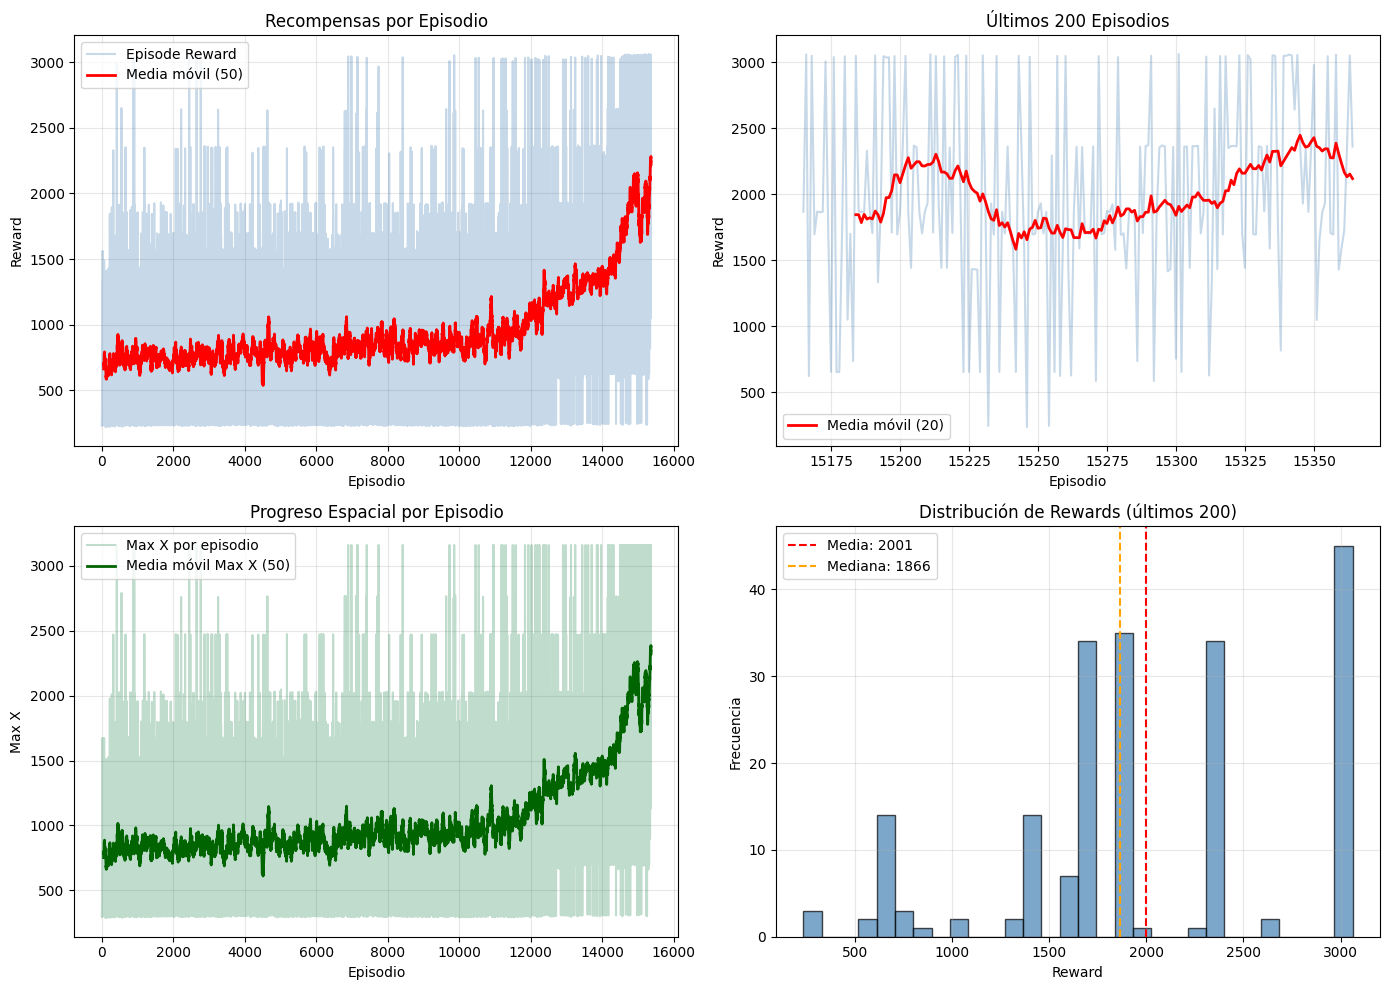


ESTADÍSTICAS FINALES (15365 episodios)
Reward promedio (últimos 20): 2117.4
Reward promedio (últimos 50): 2274.9
Reward mediana (últimos 50):  2359.0
Reward máximo: 3061.0
Reward mínimo: 221.0
Max X promedio (últimos 20):  2224
Max X máximo:                 3161

🔍 DIAGNÓSTICO DEL ENTRENAMIENTO

📊 Estadísticas Generales:
   Total episodios: 15365
   Reward promedio: 955.31
   Reward std: 559.09
   Reward máximo: 3061.00
   Reward mínimo: 221.00

📈 Tendencia:
   Primera mitad avg: 779.05
   Segunda mitad avg: 1131.55
   Mejora: +352.51 ✅ (Buena progresión)

🎯 Últimos 10 episodios:
   Promedio: 2202.10
   Mejor: 3056.00
   Peor: 1429.00
   Std: 625.27 ⚠️  (Alta varianza - exploración activa)

📉 Análisis de estancamiento (últimos 30):
   Pendiente del promedio móvil: -33.740
   ⚠️  Decayendo - posible overfitting



In [12]:
import numpy as np
import matplotlib.pyplot as plt

# ========== ENTRENAMIENTO VECTORIZADO ==========
total_timesteps = 2_000_000  # 2M frames (~30-60 min con DummyVecEnv en CPU)

total_rewards, max_x_positions = train_ppo_vec(
    vec_env,
    model,
    n_envs=N_ENVS,
    n_steps=128,                # Steps por env por update
    total_timesteps=total_timesteps,
    num_epochs=4,
    batch_size=256,             # Mini-batch para SGD
    gamma=0.99,
    gae_lambda=0.95,
    learning_rate=2.5e-4,
    clip_ratio=0.2,
    entropy_coef=0.01,
    value_coef=0.5,
    device=device,
    checkpoint_freq=50,
    checkpoint_path="mario_ppo_vec.pt",
)

vec_env.close()

# ========== VISUALIZACIÓN ==========
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Rewards por episodio
ax = axes[0, 0]
ax.plot(total_rewards, alpha=0.3, label='Episode Reward', color='steelblue')
if len(total_rewards) >= 50:
    avg = np.convolve(total_rewards, np.ones(50)/50, mode='valid')
    ax.plot(range(49, len(total_rewards)), avg, label='Media móvil (50)', linewidth=2, color='red')
ax.set_xlabel('Episodio')
ax.set_ylabel('Reward')
ax.set_title('Recompensas por Episodio')
ax.legend()
ax.grid(alpha=0.3)

# 2. Últimos episodios (zoom)
ax = axes[0, 1]
window = min(200, len(total_rewards))
recent = total_rewards[-window:]
ax.plot(range(len(total_rewards) - window, len(total_rewards)), recent, alpha=0.3, color='steelblue')
if len(recent) >= 20:
    avg_r = np.convolve(recent, np.ones(20)/20, mode='valid')
    ax.plot(range(len(total_rewards) - window + 19, len(total_rewards)), avg_r,
            linewidth=2, color='red', label='Media móvil (20)')
ax.set_xlabel('Episodio')
ax.set_ylabel('Reward')
ax.set_title(f'Últimos {window} Episodios')
ax.legend()
ax.grid(alpha=0.3)

# 3. Max X por episodio
ax = axes[1, 0]
ax.plot(max_x_positions, alpha=0.3, color='seagreen', label='Max X por episodio')
if len(max_x_positions) >= 50:
    avg_x = np.convolve(max_x_positions, np.ones(50)/50, mode='valid')
    ax.plot(range(49, len(max_x_positions)), avg_x, linewidth=2, color='darkgreen',
            label='Media móvil Max X (50)')
ax.set_xlabel('Episodio')
ax.set_ylabel('Max X')
ax.set_title('Progreso Espacial por Episodio')
ax.legend()
ax.grid(alpha=0.3)

# 4. Distribución de rewards (últimos 200 episodios)
ax = axes[1, 1]
last_n = min(200, len(total_rewards))
ax.hist(total_rewards[-last_n:], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(np.mean(total_rewards[-last_n:]), color='red', linestyle='--',
           label=f'Media: {np.mean(total_rewards[-last_n:]):.0f}')
ax.axvline(np.median(total_rewards[-last_n:]), color='orange', linestyle='--',
           label=f'Mediana: {np.median(total_rewards[-last_n:]):.0f}')
ax.set_xlabel('Reward')
ax.set_ylabel('Frecuencia')
ax.set_title(f'Distribución de Rewards (últimos {last_n})')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ========== ESTADÍSTICAS ==========
print(f"\n{'='*60}")
print(f"ESTADÍSTICAS FINALES ({len(total_rewards)} episodios)")
print(f"{'='*60}")
print(f"Reward promedio (últimos 20): {np.mean(total_rewards[-20:]):.1f}")
if len(total_rewards) >= 50:
    print(f"Reward promedio (últimos 50): {np.mean(total_rewards[-50:]):.1f}")
print(f"Reward mediana (últimos 50):  {np.median(total_rewards[-50:]):.1f}")
print(f"Reward máximo: {max(total_rewards):.1f}")
print(f"Reward mínimo: {min(total_rewards):.1f}")
if len(max_x_positions) >= 20:
    print(f"Max X promedio (últimos 20):  {np.mean(max_x_positions[-20:]):.0f}")
    print(f"Max X máximo:                 {max(max_x_positions):.0f}")
print(f"{'='*60}")

diagnostico_training(total_rewards)


## Configuración del Entrenamiento Vectorizado

**Arquitectura:**
- CNN Actor-Critic (Nature DQN backbone + Actor/Critic heads)
- Input: 4 frames en escala de grises de 84×84
- Inicialización ortogonal para mejor estabilidad

**Parámetros clave:**
- **n_envs=8**: 8 entornos en paralelo → batches 8× más diversos
- **n_steps=128**: Pasos por env antes de cada update → batch de 1024 transiciones
- **total_timesteps=2M**: Presupuesto total de frames (~2000 updates)
- **num_epochs=4**: Reutilizar cada batch 4 veces
- **batch_size=256**: Mini-batch para SGD dentro de cada época
- **learning_rate=2.5e-4**: Tasa de aprendizaje estándar para PPO
- **clip_ratio=0.2**: PPO clipping
- **entropy_coef=0.01**: Incentivo de exploración
- **gamma=0.99, lambda=0.95**: Descuento y GAE

**¿Por qué debería funcionar mejor?**
- Cada update usa datos de 8 trayectorias independientes → gradientes menos ruidosos
- El batch size efectivo es 128×8=1024, vs ~500 del single-env → estimates más estables
- Más episodios completados por update → feedback más frecuente
- El reward shaping ahora está en el wrapper → consistente incluso con auto-reset

**Expectativas:**
- Primeros ~100 episodios: exploración, rewards bajos
- Episodios 100-500: aprende a avanzar hacia la derecha de forma consistente
- Episodios 500+: debería mejorar progresivamente, pasando obstáculos

In [13]:
"""
=== INFERENCIA: USAR EL MODELO ENTRENADO ===

Jugamos episodios usando la política aprendida con acción determinista (greedy).
Usamos un entorno simple (sin reward shaping ni EpisodeMonitor) para evaluar.
"""

def play_episode(env, model, device="cpu", max_steps=2000):
    """
    Juega un episodio completo usando la política aprendida.
    Usa acción greedy (argmax) en vez de sampling para evaluar.
    """
    model.eval()
    state = env.reset()
    total_reward = 0
    done = False
    steps = 0
    max_x = 40
    
    while not done and steps < max_steps:
        state_np = np.array(state, dtype=np.float32).copy()
        state_tensor = torch.tensor(state_np / 255.0, dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():
            action_logits, _ = model(state_tensor)
            action = action_logits.argmax(dim=-1)
        
        state, reward, done, info = env.step(action.item())
        total_reward += reward
        max_x = max(max_x, info.get('x_pos', 0))
        steps += 1
    
    model.train()
    return total_reward, steps, max_x

# ===== EVALUACIÓN =====
# Cargar mejor modelo si existe
best_path = "mario_ppo_vec_best.pt"
try:
    model, _ = load_checkpoint(model, best_path, device)
    print(f"Cargado mejor modelo desde {best_path}")
except (FileNotFoundError, RuntimeError):
    print("Usando modelo actual (no se encontró best checkpoint)")

print("Evaluando modelo entrenado (10 episodios, greedy)...\n")

# Entorno simple para evaluación (sin reward shaping)
eval_env = make_mario_env(world=1, stage=1)
test_rewards = []
test_x_positions = []

for i in range(10):
    reward, steps, max_x = play_episode(eval_env, model, device=device)
    test_rewards.append(reward)
    test_x_positions.append(max_x)
    print(f"  Episodio {i+1:2d}: Reward = {reward:7.1f} | Steps = {steps:4d} | Max X = {max_x:.0f}")

print(f"\n{'='*50}")
print(f"Reward promedio:  {np.mean(test_rewards):.1f} ± {np.std(test_rewards):.1f}")
print(f"Reward mediana:   {np.median(test_rewards):.1f}")
print(f"Reward máximo:    {max(test_rewards):.1f}")
print(f"X position avg:   {np.mean(test_x_positions):.0f}")
print(f"X position max:   {max(test_x_positions):.0f}")
print(f"{'='*50}")
eval_env.close()


Cargado mejor modelo desde mario_ppo_vec_best.pt
Evaluando modelo entrenado (10 episodios, greedy)...



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-10-47c57db66875>:193: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted

  Episodio  1: Reward =  1786.0 | Steps = 2000 | Max X = 2226
  Episodio  2: Reward =  1786.0 | Steps = 2000 | Max X = 2226
  Episodio  3: Reward =  1786.0 | Steps = 2000 | Max X = 2226
  Episodio  4: Reward =  1786.0 | Steps = 2000 | Max X = 2226
  Episodio  5: Reward =  1786.0 | Steps = 2000 | Max X = 2226
  Episodio  6: Reward =  1786.0 | Steps = 2000 | Max X = 2226
  Episodio  7: Reward =  1786.0 | Steps = 2000 | Max X = 2226
  Episodio  8: Reward =  1786.0 | Steps = 2000 | Max X = 2226
  Episodio  9: Reward =  1786.0 | Steps = 2000 | Max X = 2226
  Episodio 10: Reward =  1786.0 | Steps = 2000 | Max X = 2226

Reward promedio:  1786.0 ± 0.0
Reward mediana:   1786.0
Reward máximo:    1786.0
X position avg:   2226
X position max:   2226
